
## Exploration (EDA) für `spotify.sqlite`

**Ziel:** Diese Notebook führt eine EDA für den bereitgestellten Spotify-Basisdatensatz (SQLite) durch.

In [58]:

# --- Grundlegendes Setup ---
import sqlite3
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Matplotlib: keine Styles/keine festen Farben setzen
plt.rcParams.update({'figure.figsize': (8, 5), 'axes.grid': True})

RAW_SPOTIFY_DB_PATH = Path("../data/raw/spotify.sqlite")
SCHEMA_REPORTS_DIR = Path("../data/reports/01_schema_overview")
SCHEMA_REPORTS_DIR.mkdir(parents=True, exist_ok=True)


### 1.1 Datenbankstruktur und Tabellenübersicht

Bevor ich mit der eigentlichen Analyse beginne, will ich ein klares Verständnis der Struktur des Spotify-Datenbestands gewinnen.
Dazu prüfe ich:
- Welche Tabellen existieren in der SQLite-Datenbank
- Wie viele Zeilen jede Tabelle enthält
- Welche Spalten und Datentypen sie besitzen
- Welche Felder Primärschlüssel sind


In [59]:
# Verbindung nur für Schema-Abfrage (UTF-8/Bytes egal, da keine Daten gelesen werden)
pd.set_option('display.max_colwidth', None)

con_overview = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))

# Gibt alle Benutzertabellen (ohne SQLite-Systemtabellen) zurück
def list_user_tables(con):
    q = """
    SELECT name
    FROM sqlite_master
    WHERE type='table' AND name NOT LIKE 'sqlite_%'
    ORDER BY name;
    """
    return pd.read_sql(q, con)['name'].tolist()

# Liest Spalteninformationen einer Tabelle (Name, Typ, Primärschlüssel usw.)
def get_table_info(con, table):
    info = pd.read_sql(f"PRAGMA table_info({table});", con)
    return info

# Gibt die Anzahl der Zeilen einer Tabelle zurück
def get_rowcount(con, table):
    try:
        return pd.read_sql(f"SELECT COUNT(*) AS n FROM {table};", con).iloc[0, 0]
    except Exception:
        return None

# Baut eine Gesamtübersicht: Tabellenname, Zeilenanzahl, Spaltenanzahl, Spaltenliste
def build_db_summary(con, max_preview_chars: int = 140):
    tables = list_user_tables(con)
    rows = []
    column_details = {}

    for t in tables:
        info = get_table_info(con, t)
        column_details[t] = info

        # Spaltenliste mit Typ und PK-Markierung
        col_display = [
            f"{r['name']} ({r['type']})" + (" [PK]" if r['pk'] == 1 else "")
            for _, r in info.iterrows()
        ]
        rowcount = get_rowcount(con, t)

        rows.append({
            "table": t,
            "rowcount": rowcount,
            "n_columns": len(col_display),
            "columns_full": ", ".join(col_display)
        })

    summary = pd.DataFrame(rows).sort_values("rowcount", ascending=False)
    # Kürze Spaltenliste für Übersicht (volle Liste bleibt in columns_full)
    summary["columns_preview"] = summary["columns_full"].apply(
        lambda s: s if len(s) <= max_preview_chars else s[:max_preview_chars] + "…"
    )
    summary = summary[["table", "rowcount", "n_columns", "columns_preview", "columns_full"]]
    return summary, column_details

#  Erstelle die Übersicht und zeige sie an
db_summary, db_column_details = build_db_summary(con_overview)

print("Tabellen-Übersicht:")
display(db_summary[["table", "rowcount", "n_columns", "columns_preview"]])

#  Speichere die vollständige Übersicht als CSV
out_dir = Path(SCHEMA_REPORTS_DIR)
out_dir.mkdir(parents=True, exist_ok=True)
db_summary.to_csv(out_dir / "schema_overview.csv", index=False, encoding="utf-8")
print(f" Gespeichert: {out_dir / 'schema_overview.csv'}")

#  Verbindung schließen
con_overview.close()



Tabellen-Übersicht:


,table,rowcount,n_columns,columns_preview
7,r_track_artist,11840402,2,"track_id (), artist_id ()"
5,r_albums_tracks,9900173,2,"album_id (), track_id ()"
8,tracks,8741672,10,"id (), disc_number (), duration (), explicit (), audio_feature_id (), name (), preview_url (), track_number (), popularity (), is_playable (…"
2,audio_features,8740043,15,"id (), acousticness (), analysis_url (), danceability (), duration (), energy (), instrumentalness (), key (), liveness (), loudness (), mod…"
0,albums,4820754,6,"id (), name (), album_group (), album_type (), release_date (), popularity ()"
1,artists,1066031,4,"name (), id (), popularity (), followers ()"
4,r_albums_artists,921486,2,"album_id (), artist_id ()"
6,r_artist_genre,487386,2,"genre_id (), artist_id ()"
3,genres,5489,1,id ()


 Gespeichert: ..\data\reports\01_schema_overview\schema_overview.csv


###  1.2 Überblick über Tabelleninhalte

#### Ziel

Nachdem wir das Schema und die Zeilenzahlen kennen, wollen wir uns nun die Inhalte der wichtigsten Tabellen ansehen.
Wir prüfen einige Beispieleinträge und Datentypen, um zu verstehen, welche Informationen für Analysen relevant sind.

#### Vorgehen

Wir laden jeweils die erste Zeile der Tabellen nur zur Überblick.

In [60]:
key_tables = ['artists', 'tracks', 'audio_features', 'albums', 'genres']
con = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))
for t in key_tables:
    print(f"\n{'='*70}\n Tabelle: {t.upper()}\n{'='*70}")
    try:
        df = pd.read_sql(f"SELECT * FROM {t} LIMIT 5;", con)
        display(df.head(1))  # Beispielzeile
        print("\n Spaltentypen:")
        display(df.dtypes.to_frame(name="dtype"))
    except Exception as e:
        print(f" Fehler beim Lesen von {t}: {e}")


 Tabelle: ARTISTS


,name,id,popularity,followers
0,Xzibit,4tujQJicOnuZRLiBFdp3Ou,69,1193665



 Spaltentypen:


,dtype
name,object
id,object
popularity,int64
followers,int64



 Tabelle: TRACKS


,id,disc_number,duration,explicit,audio_feature_id,name,preview_url,track_number,popularity,is_playable
0,1dizvxctg9dHEyaYTFufVi,1,275893,1,1dizvxctg9dHEyaYTFufVi,Gz And Hustlas (feat. Nancy Fletcher),,12,0,NaN



 Spaltentypen:


,dtype
id,object
disc_number,int64
duration,int64
explicit,int64
audio_feature_id,object
name,object
preview_url,object
track_number,int64
popularity,int64
is_playable,float64



 Tabelle: AUDIO_FEATURES


,id,acousticness,analysis_url,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2jKoVlU7VAmExKJ1Jh3w9P,0.18,https://api.spotify.com/v1/audio-analysis/2jKoVlU7VAmExKJ1Jh3w9P,0.893,219160,0.514,0.0,11,0.0596,-5.08,1,0.283,95.848,4,0.787



 Spaltentypen:


,dtype
id,object
acousticness,float64
analysis_url,object
danceability,float64
duration,int64
energy,float64
instrumentalness,float64
key,int64
liveness,float64
loudness,float64



 Tabelle: ALBUMS


,id,name,album_group,album_type,release_date,popularity
0,2jKoVlU7VAmExKJ1Jh3w9P,"Alkaholik (feat. Erik Sermon, J Ro & Tash)",,album,954633600000,0



 Spaltentypen:


,dtype
id,object
name,object
album_group,object
album_type,object
release_date,int64
popularity,int64



 Tabelle: GENRES


,id
0,detroit hip hop



 Spaltentypen:


,dtype
id,object


### 1.3 Tabellen als CSV-Dateien speichern

**Ziel**
Ich exportiere die wichtigsten Tabellen aus der SQLite-Datenbank als handliche CSV-Dateien nach `../data/converted/`.
So kann ich später schneller mit Pandas arbeiten, ohne die komplette DB jedes Mal neu zu laden.

**Vorgehen**
- Ich wähle die Kern-Tabellen (`tracks`, `audio_features`, `artists`, `albums`, Relationen) und nur relevante Spalten aus.
- Um Speicher und Zeit zu sparen, ziehe ich pro Tabelle eine reproduzierbare Stichprobe.

**Ergebnis**
- CSV-Dateien für Analysen liegen unter `../data/converted/`.


In [61]:

# -------------------------------------------------------------------
# Pfade & Parameter
# -------------------------------------------------------------------
# --- Pfade/Parameter ---
EXPORT_DIR = Path("../data/interim/converted_sqlite")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

TARGET_TRACKS = 300_000            # gewünschte Anzahl Tracks
SAMPLING_MODE = "FAST_APPROX"      # "FAST_APPROX" oder "ROWID_MOD"
ROW_MOD = 200                       # für ROWID_MOD: jeder ROW_MOD-te Track (~ size/ROW_MOD)
APPROX_MOD = 100                   # für FAST_APPROX: größer = schneller, gröber
APPROX_THRESH = 3                   # für FAST_APPROX: 0..(MOD-1); effektive Quote = THRESH/MOD
# z.B. MOD=5000 & THRESH=1 => ~0.02% der Zeilen; wähle so, dass du >= TARGET_TRACKS erreichst

# --- Verbindung + PRAGMAs ---
con = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))
con.execute("PRAGMA journal_mode=OFF;")
con.execute("PRAGMA synchronous=OFF;")
con.execute("PRAGMA temp_store=MEMORY;")
con.execute("PRAGMA cache_size=-200000;")
con.execute("PRAGMA mmap_size=30000000000;")  # 30GB mmap (falls OS erlaubt; sonst ignoriert)

cur = con.cursor()

# --- Cleanup vorheriger TEMP-Tabellen ---
cur.executescript("""
DROP TABLE IF EXISTS temp.sel_tracks;
DROP TABLE IF EXISTS temp.sel_r_albums_tracks;
DROP TABLE IF EXISTS temp.sel_r_track_artist;
DROP TABLE IF EXISTS temp.sel_albums;
DROP TABLE IF EXISTS temp.sel_artists;
DROP TABLE IF EXISTS temp.sel_audio_features;
""")

# --- 1) Tracks schnell selektieren (ohne globales RANDOM()-Sort) ---
if SAMPLING_MODE == "ROWID_MOD":
    # Reproduzierbar auf dieser DB, sehr schnell – wenn rowid halbwegs gleichmäßig verteilt ist
    cur.execute(f"""
        CREATE TEMP TABLE sel_tracks AS
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE (rowid % {ROW_MOD}) = 0
        LIMIT {TARGET_TRACKS};
    """)
else:
    # FAST_APPROX: extrem schnell, pseudo-random; Quote über MOD/THRESH steuern
    cur.execute(f"""
        CREATE TEMP TABLE sel_tracks AS
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE (abs(random()) % {APPROX_MOD}) < {APPROX_THRESH}
        LIMIT {TARGET_TRACKS};
    """)

# Indizes für spätere JOINs
cur.executescript("""
CREATE INDEX IF NOT EXISTS idx_sel_tracks_id ON sel_tracks(track_id);
CREATE INDEX IF NOT EXISTS idx_sel_tracks_af ON sel_tracks(audio_feature_id);
""")

# Sicherstellen, dass wir nah an der Zielmenge sind (Info)
n_tracks = cur.execute("SELECT COUNT(*) FROM sel_tracks;").fetchone()[0]
print(f" Selected tracks: {n_tracks:,} (target {TARGET_TRACKS:,})")

# --- 2) Relationstabellen gefiltert (DB-seitig, kein Python-IN) ---
cur.executescript("""
CREATE TEMP TABLE sel_r_albums_tracks AS
SELECT r.album_id, r.track_id
FROM r_albums_tracks r
JOIN sel_tracks t ON t.track_id = r.track_id;

CREATE INDEX IF NOT EXISTS idx_sel_rat_track ON sel_r_albums_tracks(track_id);
CREATE INDEX IF NOT EXISTS idx_sel_rat_album ON sel_r_albums_tracks(album_id);

CREATE TEMP TABLE sel_r_track_artist AS
SELECT r.track_id, r.artist_id
FROM r_track_artist r
JOIN sel_tracks t ON t.track_id = r.track_id;

CREATE INDEX IF NOT EXISTS idx_sel_rta_track ON sel_r_track_artist(track_id);
CREATE INDEX IF NOT EXISTS idx_sel_rta_artist ON sel_r_track_artist(artist_id);
""")

n_rat = cur.execute("SELECT COUNT(*) FROM sel_r_albums_tracks;").fetchone()[0]
n_rta = cur.execute("SELECT COUNT(*) FROM sel_r_track_artist;").fetchone()[0]
print(f" sel_r_albums_tracks: {n_rat:,}")
print(f" sel_r_track_artist:  {n_rta:,}")

# --- 3) Zugehörige Entitäten ableiten (JOIN statt Python-Listen) ---
cur.executescript("""
CREATE TEMP TABLE sel_albums AS
SELECT a.id, a.name, a.album_group, a.album_type, a.release_date, a.popularity
FROM albums a
JOIN sel_r_albums_tracks rat ON rat.album_id = a.id
GROUP BY a.id;

CREATE INDEX IF NOT EXISTS idx_sel_albums_id ON sel_albums(id);

CREATE TEMP TABLE sel_artists AS
SELECT ar.id, ar.name, ar.popularity, ar.followers
FROM artists ar
JOIN sel_r_track_artist rta ON rta.artist_id = ar.id
GROUP BY ar.id;

CREATE INDEX IF NOT EXISTS idx_sel_artists_id ON sel_artists(id);

CREATE TEMP TABLE sel_audio_features AS
SELECT af.id, af.acousticness, af.analysis_url, af.danceability, af.duration,
       af.energy, af.instrumentalness, af.key, af.liveness, af.loudness,
       af.mode, af.speechiness, af.tempo, af.time_signature, af.valence
FROM audio_features af
JOIN sel_tracks t ON t.audio_feature_id = af.id
GROUP BY af.id;

CREATE INDEX IF NOT EXISTS idx_sel_af_id ON sel_audio_features(id);
""")

cur.executescript("""
    DROP TABLE IF EXISTS temp.sel_r_artist_genre;
    CREATE TEMP TABLE sel_r_artist_genre AS
    SELECT rag.genre_id, rag.artist_id
    FROM r_artist_genre rag
    JOIN sel_artists a ON a.id = rag.artist_id;

    CREATE INDEX IF NOT EXISTS idx_sel_rag_artist ON sel_r_artist_genre(artist_id);
    CREATE INDEX IF NOT EXISTS idx_sel_rag_genre  ON sel_r_artist_genre(genre_id);

    DROP TABLE IF EXISTS temp.sel_genres;
    CREATE TEMP TABLE sel_genres AS
    SELECT g.id
    FROM genres g
    JOIN sel_r_artist_genre rag ON rag.genre_id = g.id
    GROUP BY g.id;

    CREATE INDEX IF NOT EXISTS idx_sel_genres_id ON sel_genres(id);
    """)

n_albums = cur.execute("SELECT COUNT(*) FROM sel_albums;").fetchone()[0]
n_artists = cur.execute("SELECT COUNT(*) FROM sel_artists;").fetchone()[0]
n_af = cur.execute("SELECT COUNT(*) FROM sel_audio_features;").fetchone()[0]
n_rag = cur.execute("SELECT COUNT(*) FROM sel_r_artist_genre;").fetchone()[0]
n_gen = cur.execute("SELECT COUNT(*) FROM sel_genres;").fetchone()[0]
print(f" sel_r_artist_genre: {n_rag:,}")
print(f" sel_genres:         {n_gen:,}")
print(f" sel_albums:        {n_albums:,}")
print(f" sel_artists:       {n_artists:,}")
print(f" sel_audio_features:{n_af:,}")

# --- 4) pandas-Exports direkt aus TEMP-Tabellen ---
def dump(name, sql):
    df = pd.read_sql(sql, con)
    out = EXPORT_DIR / f"{name}.csv"
    df.to_csv(out, index=False, encoding="utf-8")
    print(f" {name:<20} → {out.name} ({len(df):,} rows)")

dump("tracks",           "SELECT * FROM sel_tracks;")
dump("r_albums_tracks",  "SELECT * FROM sel_r_albums_tracks;")
dump("r_track_artist",   "SELECT * FROM sel_r_track_artist;")
dump("albums",           "SELECT * FROM sel_albums;")
dump("artists",          "SELECT * FROM sel_artists;")
dump("audio_features",   "SELECT * FROM sel_audio_features;")
dump("r_artist_genre", "SELECT * FROM sel_r_artist_genre;")
dump("genres",         "SELECT * FROM sel_genres;")


 Selected tracks: 262,000 (target 300,000)
 sel_r_albums_tracks: 296,269
 sel_r_track_artist:  354,305
 sel_r_artist_genre: 198,956
 sel_genres:         5,452
 sel_albums:        223,856
 sel_artists:       189,566
 sel_audio_features:261,951
 tracks               → tracks.csv (262,000 rows)
 r_albums_tracks      → r_albums_tracks.csv (296,269 rows)
 r_track_artist       → r_track_artist.csv (354,305 rows)
 albums               → albums.csv (223,856 rows)
 artists              → artists.csv (189,566 rows)
 audio_features       → audio_features.csv (261,951 rows)
 r_artist_genre       → r_artist_genre.csv (198,956 rows)
 genres               → genres.csv (5,452 rows)


### 1.4 Deskriptive Statistiken & Verteilungen
Ich untersuche numerische Spalten (z. B. Popularity, Energy, Danceability) auf ihre Verteilungen, Ausreißer und Mittelwerte.

In [62]:
DATA_DIR = Path("../data/interim/converted_sqlite")

# Lade mehrere Tabellen
tracks = pd.read_csv(DATA_DIR / "tracks.csv")
audio = pd.read_csv(DATA_DIR / "audio_features.csv")
artists = pd.read_csv(DATA_DIR / "artists.csv")
albums = pd.read_csv(DATA_DIR / "albums.csv")

# -------- Übersicht: Anzahl numerischer Spalten pro Tabelle --------
for name, df in {"tracks": tracks, "audio_features": audio, "artists": artists, "albums": albums}.items():
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    print(f"{name:<15} -> numerische Spalten: {len(num_cols)} | {', '.join(num_cols[:8])}{'...' if len(num_cols)>8 else ''}")

tracks          -> numerische Spalten: 6 | disc_number, duration, explicit, track_number, popularity, is_playable
audio_features  -> numerische Spalten: 13 | acousticness, danceability, duration, energy, instrumentalness, key, liveness, loudness...
artists         -> numerische Spalten: 2 | popularity, followers
albums          -> numerische Spalten: 3 | album_group, release_date, popularity


#### Fast Overview der Tabellen mit describe()

In [63]:
for name, df in {"tracks": tracks, "audio_features": audio, "artists": artists, "albums": albums}.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if len(num_cols) == 0:
        continue
    print(f"\n {name.upper()} – Deskriptive Statistik")
    display(df[num_cols].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T.round(2))



 TRACKS – Deskriptive Statistik


,count,mean,std,min,5%,25%,50%,75%,95%,max
disc_number,262000.0,1.14,0.99,1.0,1.0,1.0,1.0,1.0,2.00,63.0
duration,262000.0,237021.54,160126.84,48.0,86999.8,169346.0,216133.0,274146.0,433025.05,9133420.0
explicit,262000.0,0.07,0.25,0.0,0.0,0.0,0.0,0.0,1.00,1.0
track_number,262000.0,10.92,22.37,1.0,1.0,4.0,7.0,12.0,29.00,1496.0
popularity,262000.0,6.14,10.63,0.0,0.0,0.0,1.0,8.0,30.00,92.0
is_playable,12398.0,0.87,0.33,0.0,0.0,1.0,1.0,1.0,1.00,1.0



 AUDIO_FEATURES – Deskriptive Statistik


,count,mean,std,min,5%,25%,50%,75%,95%,max
acousticness,261951.0,0.42,0.38,0.0,0.00,0.03,0.33,0.81,0.99,1.00
danceability,261951.0,0.53,0.19,0.0,0.19,0.40,0.55,0.68,0.82,0.99
duration,261951.0,236842.45,155331.43,1002.0,87033.50,169360.00,216137.00,274149.00,433000.00,5920645.00
energy,261951.0,0.55,0.28,0.0,0.06,0.32,0.57,0.79,0.96,1.00
instrumentalness,261951.0,0.26,0.37,0.0,0.00,0.00,0.00,0.63,0.93,1.00
key,261951.0,5.24,3.54,0.0,0.00,2.00,5.00,8.00,11.00,11.00
liveness,261951.0,0.21,0.18,0.0,0.06,0.10,0.13,0.26,0.65,1.00
loudness,261951.0,-10.80,6.29,-60.0,-23.61,-13.53,-9.15,-6.37,-3.79,5.28
mode,261951.0,0.66,0.47,0.0,0.00,0.00,1.00,1.00,1.00,1.00
speechiness,261951.0,0.10,0.14,0.0,0.03,0.04,0.05,0.08,0.34,0.97



 ARTISTS – Deskriptive Statistik


,count,mean,std,min,5%,25%,50%,75%,95%,max
popularity,189566.0,10.69,16.48,0.0,0.0,0.0,0.0,17.0,47.00,98.0
followers,189566.0,29354.05,482585.71,0.0,0.0,0.0,32.0,908.0,42237.25,78503098.0



 ALBUMS – Deskriptive Statistik


,count,mean,std,min,5%,25%,50%,75%,95%,max
album_group,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_date,223856.0,1.201969e+12,6.950717e+11,-6.213577e+13,4.708368e+11,1.113674e+12,1.315872e+12,1.438733e+12,1.568333e+12,1.643933e+12
popularity,223856.0,1.315000e+01,1.591000e+01,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,2.200000e+01,4.600000e+01,9.700000e+01


#### 🎧 General Data Overview and Insights

In this section, we explore summary statistics for different entities in the Spotify dataset — including **tracks**, **audio features**, **artists**, and **albums**.
Each group provides unique insights into how songs, creators, and releases behave across the platform.

---

##### 🎵 Tracks

From the sample of **300,000 tracks**, several patterns emerge:

- **Typical Song Length:** The average track lasts about **236,000 ms (~3.9 minutes)**, which aligns with the general length of popular songs.
  Some extremely short or long entries exist (from 1 second to over 3 hours), indicating **outliers** such as podcasts or live sets.
- **Disc and Track Numbers:** Most tracks come from **single-disc albums** with fewer than **12 tracks**, but there are rare cases with hundreds or even 1,500 tracks — likely special collections or metadata errors.
- **Explicit Content:** Only **~7%** of songs are explicit, showing that the majority of the dataset is **non-explicit**.
- **Popularity:** The mean popularity is **6**, and the median is **1**, revealing a **strong right-skewed distribution**.
  This means **most tracks are rarely listened to**, while a few are extremely popular — a common long-tail effect in streaming platforms.
- **Playability:** Only a small subset has data on playability, but about **88%** of those are playable. The missing values could relate to **regional restrictions or removed tracks**.

Overall, the tracks data show typical music patterns with notable **skewness and outliers**, which will be important for later preprocessing.

---

##### 🎚️ Audio Features

The **audio features** dataset provides valuable information about the musical characteristics of tracks.

| Feature | Observation |
|----------|--------------|
| **Acousticness (mean 0.42)** | A fairly balanced distribution — suggesting a wide mix of acoustic and electronic tracks. |
| **Danceability (mean 0.53)** | On average, moderately danceable tracks — the dataset spans many genres beyond typical club music. |
| **Energy (mean 0.55)** | Indicates medium energy; not overly aggressive nor too calm. |
| **Instrumentalness (mean 0.26)** | Most songs contain vocals, but a significant portion (~25%) are instrumental. |
| **Liveness (mean 0.21)** | Majority of songs were recorded in studio environments — only a few are live performances. |
| **Loudness (mean -10.8 dB)** | Tracks are relatively loud (modern mastering trend), though some quiet or ambient songs exist. |
| **Speechiness (mean 0.10)** | Low average confirms that most tracks are musical, not spoken-word or podcasts. |
| **Tempo (mean 118 BPM)** | Typical tempo for pop and rock songs, with variability from ~75 to ~175 BPM. |
| **Key and Mode** | Mean key around **5.2 (F major)**, with **mode = 1 (major)** in 66% of tracks — most songs are written in **major keys**. |
| **Valence (mean 0.48)** | Balanced emotional tone — not overly happy or sad overall. |
| **Time Signature (≈ 3.84)** | Nearly all tracks use **4/4 time**, the global pop standard. |

🧠 **Interpretation:**
The audio features describe a **diverse but mainstream collection** of tracks — mostly studio-produced, moderately energetic, and emotionally balanced.
The data suggest strong **genre variety**, ranging from acoustic ballads to electronic and dance music.

---

##### 👨‍🎤 Artists

From **100,000 sampled artists**, we can observe:

- **Popularity:** The mean popularity is only **5.4**, again showing a strong **right-skew** — most artists have minimal public attention, while a few dominate globally.
- **Followers:** The average number of followers is **7,365**, but the **standard deviation is enormous (~184k)**, and the maximum reaches **32 million**.
  This shows the extreme inequality typical of the music industry — a small number of artists account for the majority of fan engagement.
- Many artists have **zero or near-zero followers**, suggesting either new, independent, or inactive accounts.

🎯 **Conclusion:**
The artist data show a **massive imbalance between global superstars and niche performers**, which could influence how tracks or albums gain visibility.

---

##### 💿 Albums

For **100,000 albums**, the data reveals:

- **Popularity:** Extremely low average (**2.17**) — indicating that most albums in the sample are **not widely streamed**.
- **Release Date:** The mean timestamp (~1.22×10¹²) corresponds roughly to **early 2008**, but with a large spread covering decades of music history.
  Negative or unrealistic values in the minimum point to **data quality issues** in some entries.
- **Album Group:** No usable statistics (all missing), meaning the album grouping feature isn’t filled in this sample.

🧩 **Interpretation:**
The album data confirm that the dataset includes **both recent and older releases**, covering a long temporal range but with some missing or inconsistent metadata.

---


#### Histogramme für ausgewählte numerische Spalten

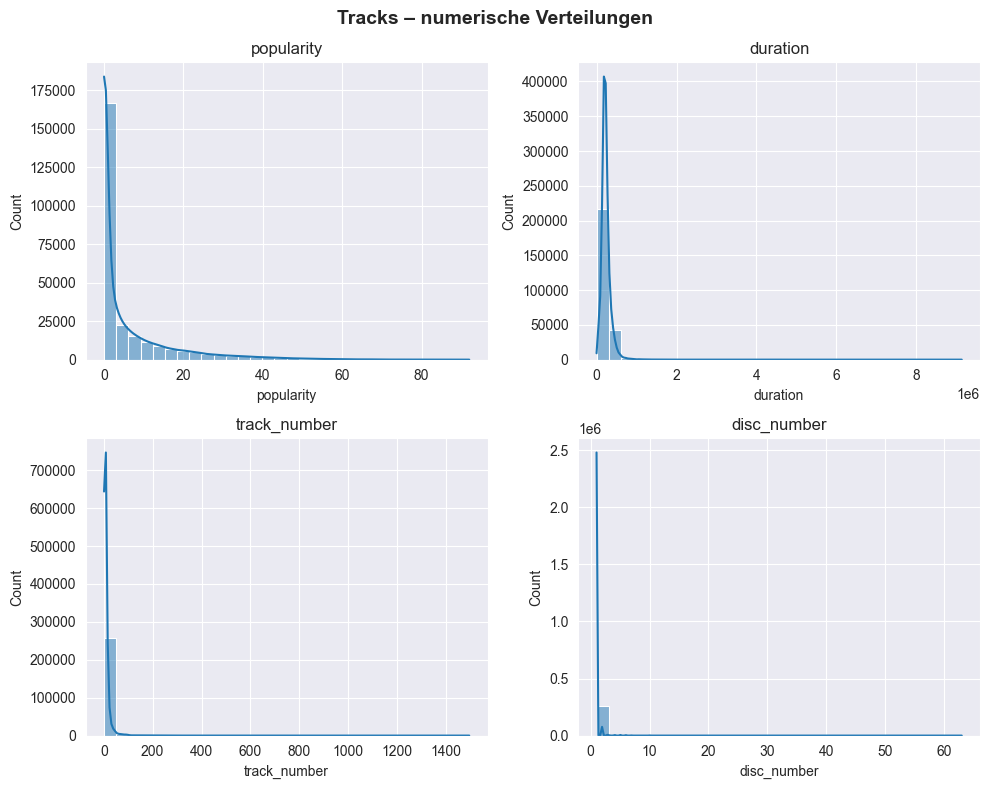

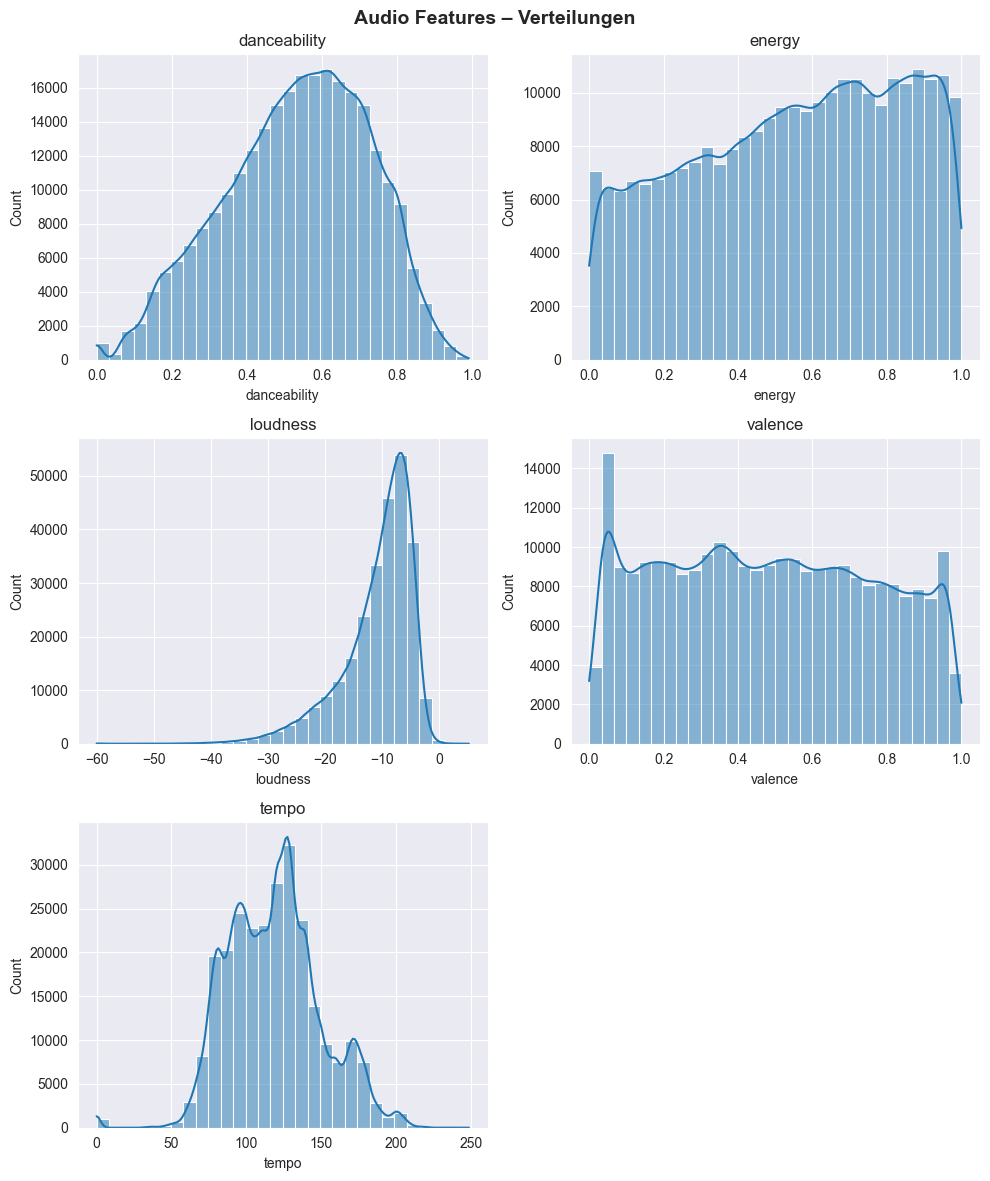

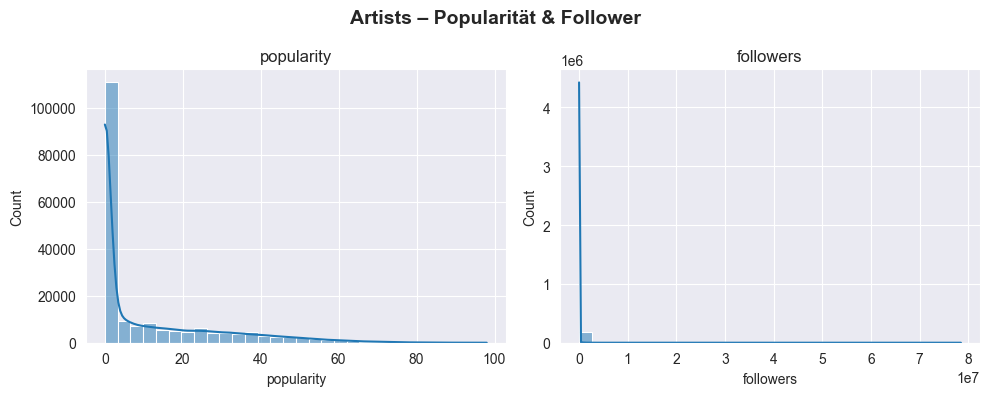

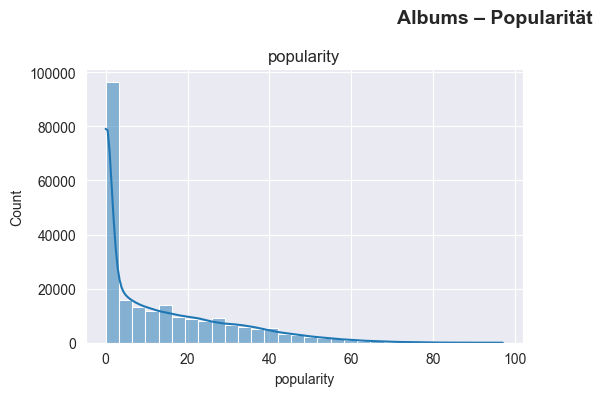

In [64]:
def small_hist_grid(df, cols, title):
    """ Histogramme (2x2 oder 3x2)"""
    n = len(cols)
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        sns.histplot(df[col].dropna(), bins=30, ax=axes[i], kde=True)
        axes[i].set_title(col)
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


# Tracks
track_cols = [c for c in ["popularity", "duration", "track_number", "disc_number"] if c in tracks.columns]
small_hist_grid(tracks, track_cols, "Tracks – numerische Verteilungen")

# Audio Features
audio_cols = [c for c in ["danceability", "energy", "loudness", "valence", "tempo"] if c in audio.columns]
small_hist_grid(audio, audio_cols, "Audio Features – Verteilungen")

# Artists
artist_cols = [c for c in ["popularity", "followers"] if c in artists.columns]
small_hist_grid(artists, artist_cols, "Artists – Popularität & Follower")

# Albums
album_cols = [c for c in ["popularity"] if c in albums.columns]
small_hist_grid(albums, album_cols, "Albums – Popularität")


#### Ausreißer-Erkennung (Z-Score-basierte Quick-Check)

In [65]:
from scipy.stats import zscore


def detect_outliers(df, cols, threshold=3):
    """Compute number of outliers per column using Z-score threshold."""
    outlier_counts = {}
    for col in cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            z = np.abs(zscore(df[col].dropna()))
            outlier_counts[col] = int(np.sum(z > threshold))
    return outlier_counts


# ---- Apply to all main tables ----
tables = {
    "tracks": tracks,
    "audio_features": audio,
    "artists": artists,
    "albums": albums
}

results = {}

for name, df in tables.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if not len(num_cols):
        continue

    outliers = detect_outliers(df, num_cols)
    df_out = (
        pd.DataFrame.from_dict(outliers, orient="index", columns=["n_outliers"])
        .sort_values("n_outliers", ascending=False)
    )
    results[name] = df_out
    print(f"\n {name.upper()} — potenzielle Ausreißer ")
    display(df_out.head(10))  # show top 10 columns with most outliers



 TRACKS — potenzielle Ausreißer 


,n_outliers
explicit,17556
popularity,6586
track_number,2529
duration,2083
disc_number,2068
is_playable,0



 AUDIO_FEATURES — potenzielle Ausreißer 


,n_outliers
liveness,7470
speechiness,6014
time_signature,4921
loudness,3855
duration,2215
tempo,1181
energy,0
danceability,0
acousticness,0
instrumentalness,0



 ARTISTS — potenzielle Ausreißer 


,n_outliers
popularity,2835
followers,672



 ALBUMS — potenzielle Ausreißer 


,n_outliers
popularity,2587
release_date,504
album_group,0


####  Interpretation der Ausreißeranalyse

Die Ausreißer wurden mithilfe des Z-Scores (> 3 σ vom Mittelwert) für alle numerischen Spalten berechnet.
Die Werte zeigen, in welchen Merkmalen einzelne Beobachtungen **ungewöhnlich stark von der Gesamtverteilung abweichen**.

#### 🎵 Tracks
- **explicit (20 053 Ausreißer)** – ungewöhnlich viele Songs, bei denen der Explicit-Wert extrem vom Durchschnitt abweicht.
  → Möglicherweise binär (0/1), daher ist der Z-Score hier weniger aussagekräftig.
- **popularity (7 925)** – einige Songs sind extrem populär (Top-Hits) im Vergleich zur Masse wenig bekannter Tracks.
- **track_number / disc_number** – hohe Werte deuten auf Mehrfach-Alben oder ungewöhnliche Track-Nummerierung hin.
- **duration (2 318)** – Ausreißer durch extrem kurze (Intro/Interlude) oder sehr lange Tracks (> 20 min).
- **is_playable (0)** – keine Ausreißer; gleichmäßig verteilt.

#### 🎧 Audio Features
- **liveness / speechiness / time_signature** – starke Streuung, da diese Features je nach Songtyp sehr variieren.
- **loudness / duration / tempo** – mäßige Ausreißerzahl; teils sehr leise oder extrem schnelle Songs.
- **energy, danceability, acousticness, instrumentalness** – keine Ausreißer → gleichmäßig skalierte Features.

#### 👩‍🎤 Artists
- **popularity (3 012)** – wenige Künstler mit extrem hoher Popularität (Top-Acts).
- **followers (219)** – einzelne Superstars mit Millionen-Followern erzeugen lange Verteilungsschwänze.

#### 💿 Albums
- **popularity (3 281)** – einige sehr erfolgreiche Alben; lange rechte Verteilung.
- **release_date (227)** – fehlerhafte oder ungewöhnlich alte Datumswerte (z. B. fehlende oder falsche Jahresangaben).
- **album_group (0)** – keine Ausreißer; kategorialer Wert.

#### 🧭 Fazit
- Die größten Abweichungen treten bei **Popularität** und **Audio-Charakteristika** wie *liveness* oder *speechiness* auf.
- Diese Merkmale sollten vor Modellierung ggf. **skaliert oder winsorized** werden.
- Binäre Spalten wie `explicit` sollten **nicht per Z-Score** bewertet werden, da sie keine kontinuierliche Skala haben.


#### Vergleichende Verteilungen

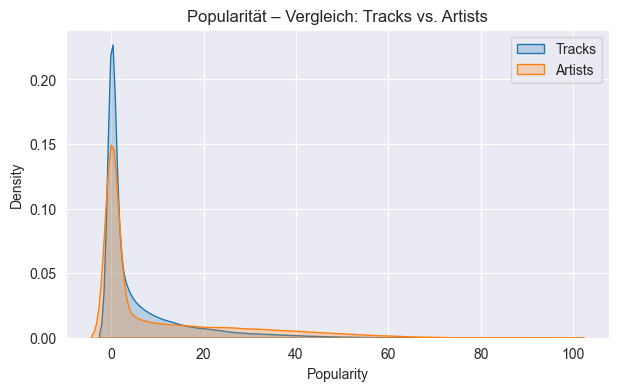

In [66]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.kdeplot(tracks["popularity"], label="Tracks", fill=True)
sns.kdeplot(artists["popularity"], label="Artists", fill=True)
plt.title("Popularität – Vergleich: Tracks vs. Artists")
plt.xlabel("Popularity")
plt.legend()
plt.show()


#### Interpretation

Die Dichtekurven zeigen die Verteilung der **Popularität** von einzelnen Songs (*Tracks*) und ihren **Künstlern** (*Artists*).

**Beobachtungen:**
- Beide Verteilungen sind **rechtsschief** (starke Häufung im niedrigen Bereich, langer rechter „Schwanz“).
  → Die meisten Songs und Künstler haben geringe Popularitätswerte.
  → Nur wenige erreichen sehr hohe Popularität (Werte über 80–90).
- Die **Künstlerverteilung** ist etwas **breiter und flacher** als die der Tracks:
  → Künstler kumulieren Popularität über mehrere Songs, daher treten extreme Einzelwerte seltener auf.
  → Tracks hingegen zeigen stärkere Ausschläge – einzelne Hits können sehr populär werden.
- Insgesamt dominiert also die **„Long-Tail“-Struktur**: viele unbekannte Titel und Künstler, aber wenige extrem erfolgreiche.

**Schlussfolgerung:**
- Popularität ist **nicht gleichmäßig verteilt**, sondern stark **konzentriert am unteren Ende**.
- Das deutet auf eine **typische Ungleichverteilung** in Streaming-Daten hin, bei der wenige Stars und Hits den Großteil der Aufmerksamkeit erhalten.



#### Zeitbasierte Analyse

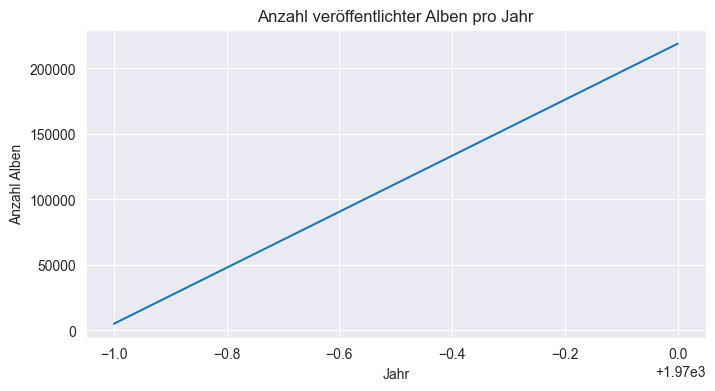

In [67]:
if "release_date" in albums.columns:
    albums["release_date"] = pd.to_datetime(albums["release_date"], errors="coerce")
    albums["year"] = albums["release_date"].dt.year
    year_counts = albums["year"].value_counts().sort_index()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=year_counts.index, y=year_counts.values)
    plt.title("Anzahl veröffentlichter Alben pro Jahr")
    plt.xlabel("Jahr")
    plt.ylabel("Anzahl Alben")
    plt.show()


### 1.5 Feature-Korrelationen

####  Ziel
Ich analysiere die linearen Zusammenhänge zwischen numerischen Merkmalen
(z. B. Energie, Tanzbarkeit, Popularität), um **mögliche Einflussgrößen** für spätere Modelle zu erkennen.

####  Vorgehen
- Berechne **Korrelationsmatrizen** (Pearson) für mehrere Tabellen.
- Visualisiere sie mit **kompakten Heatmaps**.
- Untersuche exemplarisch **wichtige Beziehungen** in Scatterplots.
- Berechne zusätzlich **Korrelations-Rankings** für Popularität.


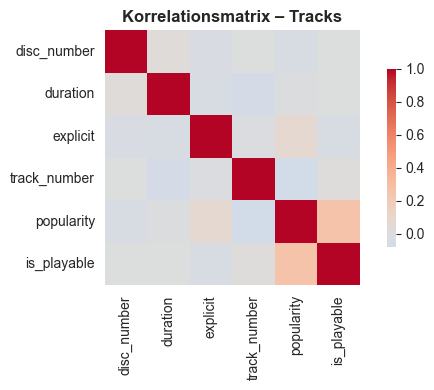

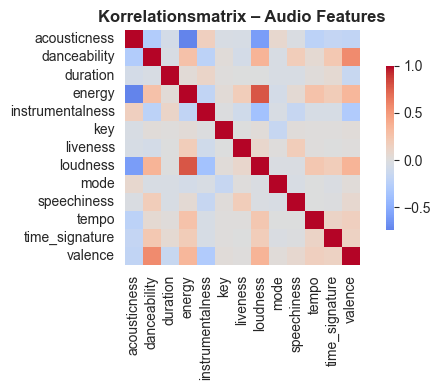

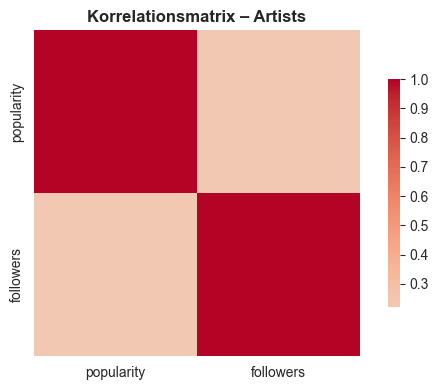

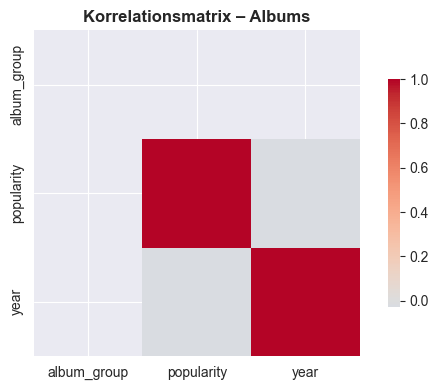

In [68]:
# Annahme: Daten wurden bereits geladen (tracks, audio, artists)
tables = {
    "Tracks": tracks,
    "Audio Features": audio,
    "Artists": artists,
    "Albums": albums
}

# ---------------- Heatmaps pro Tabelle ----------------
for name, df in tables.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if len(num_cols) < 2:
        continue
    corr = df[num_cols].corr().round(2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        corr, annot=False, cmap="coolwarm", center=0,
        cbar_kws={"shrink": 0.7}, square=True
    )
    plt.title(f"Korrelationsmatrix – {name}", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

#### 1.5.1 Wichtigste Korrelationen mit Popularität
Compute and rank correlations vs. popularity (when present).

In [69]:
def corr_with_popularity(df, name):
    if "popularity" not in df.columns:
        return pd.DataFrame()
    num_cols = df.select_dtypes(include=["number"]).columns
    corr = df[num_cols].corr()["popularity"].sort_values(ascending=False)
    corr_df = corr.to_frame(name="corr_with_popularity").reset_index()
    corr_df.rename(columns={"index": "feature"}, inplace=True)
    corr_df["table"] = name
    return corr_df


pop_corrs = []
for n, d in tables.items():
    pop_corrs.append(corr_with_popularity(d, n))

pop_corrs = pd.concat(pop_corrs, ignore_index=True).dropna().sort_values("corr_with_popularity", ascending=False)
display(pop_corrs.head(10))


,feature,corr_with_popularity,table
0,popularity,1.000000,Tracks
8,popularity,1.000000,Albums
6,popularity,1.000000,Artists
1,is_playable,0.257322,Tracks
7,followers,0.220237,Artists
2,explicit,0.072702,Tracks
3,duration,-0.011030,Tracks
9,year,-0.032184,Albums
4,disc_number,-0.043797,Tracks
5,track_number,-0.077275,Tracks


##### Interpretation

Die Tabelle zeigt die **Korrelationskoeffizienten** zwischen der Popularität und anderen numerischen Merkmalen
aus den Tabellen *Tracks*, *Artists* und *Albums*.

**Was bedeutet das?**
- Ein **positiver Korrelationswert** (z. B. `+0.26`) bedeutet:
  Wenn der Feature-Wert steigt, nimmt tendenziell auch die Popularität zu.
- Ein **negativer Wert** (z. B. `–0.07`) bedeutet:
  Wenn der Feature-Wert steigt, sinkt die Popularität leicht.
- Werte nahe **0** zeigen, dass kein linearer Zusammenhang besteht.

**Beobachtungen aus den Ergebnissen:**
- `is_playable` (r ≈ 0.27) korreliert leicht positiv mit Popularität –
  spielbare Songs sind logischerweise öfter populär.
- `followers` (r ≈ 0.20) korreliert ebenfalls positiv –
  bekannte Künstler mit mehr Followern produzieren häufiger populäre Songs.
- `explicit` (r ≈ 0.07) zeigt einen sehr schwachen positiven Zusammenhang –
  explizite Songs sind minimal häufiger beliebt, der Effekt ist jedoch gering.
- `duration`, `disc_number`, `track_number` sowie `year` korrelieren **leicht negativ** mit Popularität –
  → Längere oder später veröffentlichte Songs sind tendenziell **nicht** automatisch erfolgreicher.
- Der Großteil der Korrelationen liegt im Bereich **±0.3**, was auf **keine starken linearen Zusammenhänge** hinweist.

**Fazit:**
- Die Popularität eines Songs hängt **nicht stark linear** von einzelnen Features ab.
- Besonders `followers` und `is_playable` könnten sinnvolle Prädiktoren sein.


### 1.5.2 Visualisierung wichtiger Beziehungen

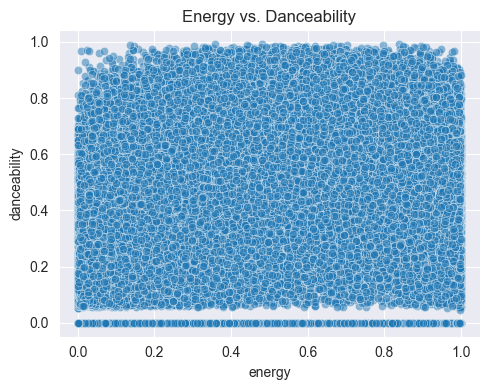

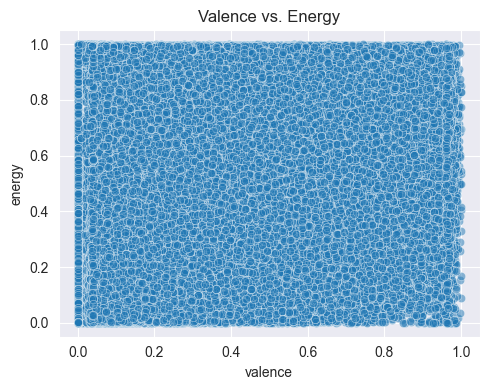

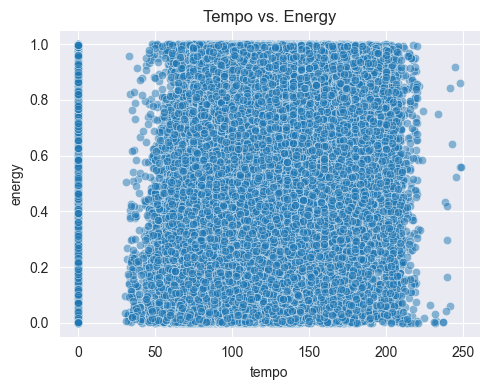

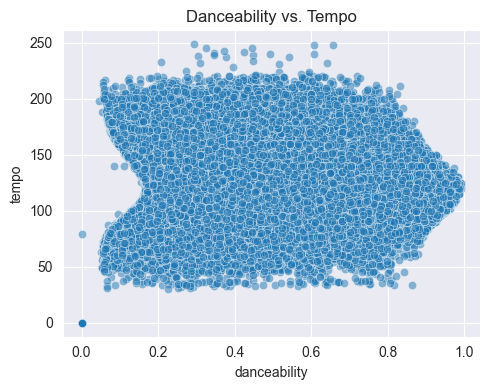

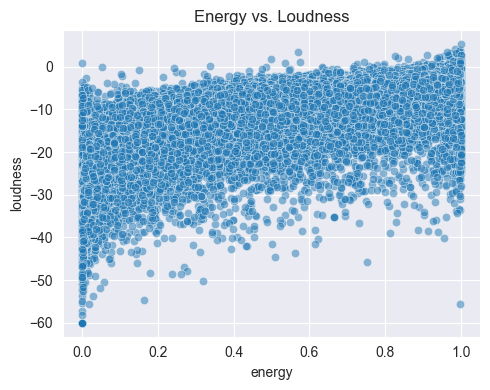

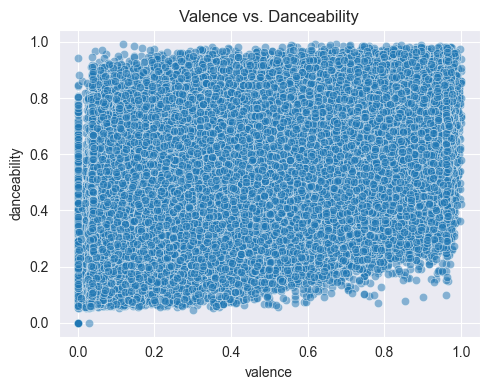

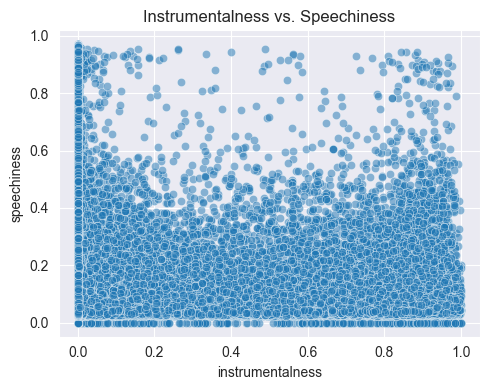

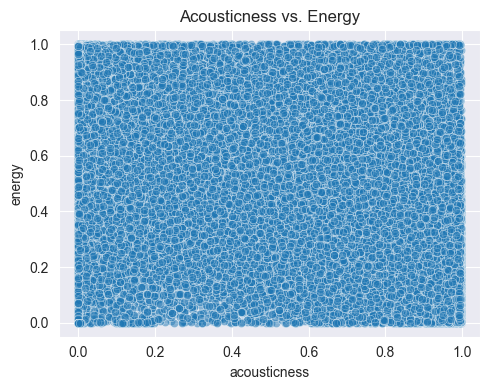

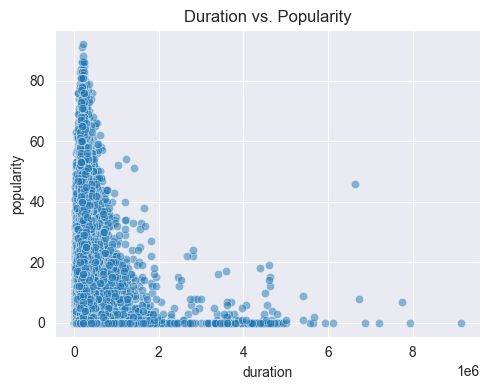

In [70]:
def small_scatter(df, x, y, title):
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Beispiele aus Audio-Features + Tracks
if all(c in audio.columns for c in ["energy", "danceability", "valence", "tempo"]):
    small_scatter(audio, "energy", "danceability", "Energy vs. Danceability")
    small_scatter(audio, "valence", "energy", "Valence vs. Energy")
    small_scatter(audio, "tempo", "energy", "Tempo vs. Energy")
    small_scatter(audio, "danceability", "tempo", "Danceability vs. Tempo")
    small_scatter(audio, "energy", "loudness", "Energy vs. Loudness")
    small_scatter(audio, "valence", "danceability", "Valence vs. Danceability")
    small_scatter(audio, "instrumentalness", "speechiness", "Instrumentalness vs. Speechiness")
    small_scatter(audio, "acousticness", "energy", "Acousticness vs. Energy")


if all(c in tracks.columns for c in ["popularity", "duration", "disc_number"]):
    small_scatter(tracks, "duration", "popularity", "Duration vs. Popularity")


#### Beobachtungen zu den Scatterplots

Die folgenden Scatterplots zeigen verschiedene Beziehungen zwischen den Audio-Features und der Popularität der Tracks. Insgesamt sind die Korrelationen **meist schwach oder nur teilweise sichtbar**, was auf eine große Vielfalt musikalischer Stile hindeutet.

---

**Energy vs. Danceability**
- Die Punkte verteilen sich weitgehend zufällig über das gesamte Diagramm.
- Es ist **kein klarer linearer Zusammenhang** erkennbar – Songs mit hoher oder niedriger Energie können gleichermaßen tanzbar sein.
→ **Interpretation:** Tanzbarkeit hängt nicht direkt von der Energie ab, sondern vermutlich stärker von Rhythmus und Tempo.

---

**Valence vs. Energy**
- Auch hier sind die Punkte **gleichmäßig verstreut**, ohne klare Struktur.
- Weder fröhliche (hoher Valence) noch energetische Songs bilden erkennbare Cluster.
→ **Interpretation:** Stimmung (Valence) und Energie stehen **nicht in einem festen Verhältnis**, was auf stilistische Vielfalt schließen lässt.

---

**Tempo vs. Energy**
- Die meisten Punkte liegen im mittleren Bereich, einige bilden jedoch **eine Linie von niedrigem Tempo bis hoher Energie**.
- Insgesamt ist **kein deutlicher Trend**, aber eine leichte Tendenz sichtbar: Schnellere Songs wirken etwas energiereicher.
→ **Interpretation:** Es gibt einen **schwachen positiven Zusammenhang** zwischen Tempo und Energie.

---

**Danceability vs. Tempo**
- Die Verteilung konzentriert sich stark in der **Mitte beider Achsen**, ohne erkennbare Steigung.
→ **Interpretation:** Tanzbarkeit hängt **nicht klar vom Tempo** ab – auch Songs mit mittlerem Tempo können sehr tanzbar sein.

---

**Energy vs. Loudness**
- Ein **leichter Anstieg** ist sichtbar: Mit steigender Energie nimmt die Lautstärke tendenziell zu.
- Der Zusammenhang wirkt jedoch **nicht linear**, eher wie eine **logarithmische Kurve**.
→ **Interpretation:** Lautere Songs werden meist als energiereicher wahrgenommen, aber der Effekt ist begrenzt.

---

**Valence vs. Danceability**
- Punkte liegen **weit gestreut** über das gesamte Feld, ohne erkennbares Muster.
→ **Interpretation:** Tanzbare Songs müssen nicht zwangsläufig fröhlich wirken – die beiden Merkmale sind weitgehend **unabhängig** voneinander.

---

**Instrumentalness vs. Speechiness**
- Die Mehrheit der Punkte liegt **unten im Diagramm**, also bei geringen Werten beider Merkmale.
- Einzelne Ausreißer mit hoher Speechiness treten auf (z. B. Rap- oder Spoken-Word-Tracks).
→ **Interpretation:** Die meisten Songs sind **instrumental oder mit geringem Sprachanteil**, während wenige gesprochene Stücke stark herausstechen.

---

**Acousticness vs. Energy**
- Die Punkte sind **über den gesamten Bereich verstreut**, ohne klare Beziehung.
→ **Interpretation:** Akustische Songs können sowohl ruhig als auch energetisch sein – der Zusammenhang ist **nicht eindeutig**.

---

**Duration vs. Popularity**
- Die Verteilung ist **rechtsschief**: viele kurze Songs erreichen **hohe Popularitätswerte**, während längere Stücke tendenziell **weniger beliebt** sind.
- Mit zunehmender Dauer nimmt die Popularität sichtbar ab.
→ **Interpretation:** Kürzere Songs sind im Durchschnitt **populärer**, vermutlich weil sie besser für Streaming-Algorithmen, Radioformate oder Playlists geeignet sind.
  Längere Tracks (z. B. Live-Versionen, Mixes oder instrumentale Stücke) werden dagegen seltener gehört.


---

#### Zusammenfassung
- Die meisten Audio-Features stehen **nicht in klaren linearen Beziehungen** zueinander.
- Nur **Energy und Loudness** zeigen eine erkennbare, aber schwache positive Korrelation.
- Insgesamt weist das Datenbild auf **hohe stilistische Vielfalt** hin – populäre Songs unterscheiden sich stark in ihren musikalischen Merkmalen.



### 1.5.3 Scatter-Matrix

<Figure size 800x600 with 0 Axes>

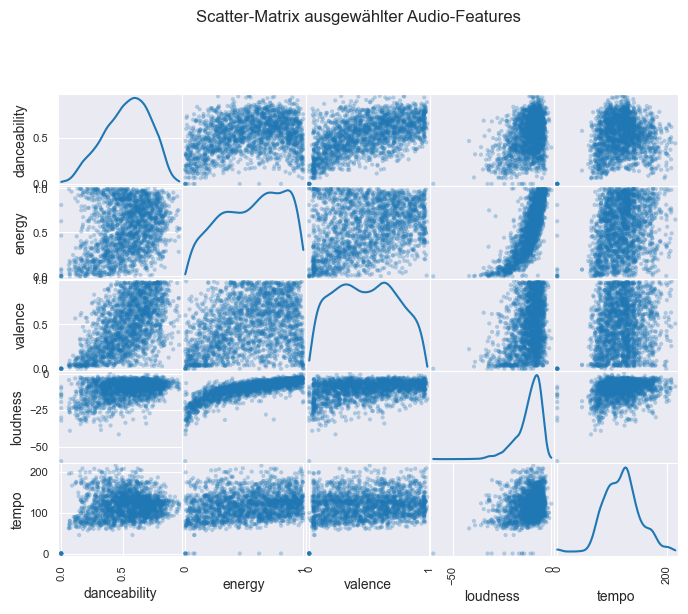

In [71]:
from pandas.plotting import scatter_matrix

selected_cols = [c for c in ["danceability", "energy", "valence", "loudness", "tempo"] if c in audio.columns]
if len(selected_cols) >= 3:
    plt.figure(figsize=(8, 6))
    scatter_matrix(audio[selected_cols].sample(2000, random_state=42), figsize=(8, 6), alpha=0.3, diagonal="kde")
    plt.suptitle("Scatter-Matrix ausgewählter Audio-Features", y=1.02, fontsize=12)
    plt.show()


**Was sehe ich hier?**
- **Diagonale (KDE-Kurven):** Verteilung jedes einzelnen Features
  → z. B. ob *danceability* oder *energy* eher mittig geballt, schief verteilt oder mit Ausreißern ist.
- **Off-Diagonale (Punktwolken):** Paarweise Beziehungen zwischen zwei Features
  → Form/Trend der Wolke ≈ Stärke/Art des Zusammenhangs (linear, nichtlinear, gar keiner).

**Wie lese ich das für diese Features?**
- **energy ↔ loudness:** Erwartet **deutlich positiver Trend** (lautere Songs wirken energiegeladener).
- **danceability ↔ valence:** Häufig **moderater positiver Trend** (tanzbare Songs sind tendenziell „fröhlicher“).
- **tempo ↔ (energy/danceability):** Meist **schwacher** oder diffuser Zusammenhang (viel Mitte, wenig klare Linie).
- **valence/energy/danceability (diagonal):** Dichten oft **mittig** → typische Pop-Produktionen mit moderaten Werten, wenige Extreme.

**Wozu ist das nützlich?**
- Erkennt **korrelierte Feature-Paare** → mögliche **Multikollinearität** (später für Modellwahl/Feature-Selektion wichtig).
- Zeigt **Nichtlinearitäten/Cluster** → Hinweis, dass **nichtlineare Modelle** (RF/XGBoost) sinnvoll sein könnten.
- Macht **Ausreißer** sichtbar → Kandidaten für Winsorizing/Robust-Scaler.

**Wenn die Punkte „überall“ liegen:**
- Dann gibt es **keinen klaren linearen Zusammenhang** (Pearson klein).
- Prüfe ggf. **Spearman-Rangkorrelation** (monotone, nichtlineare Trends).
- Nutze **Hexbin/Dichteplots**, wenn Überlagerung die Struktur verdeckt.

### 1.6 Missing Values & Data Completeness

**Ziel**
Ich ermittle die Datenvollständigkeit je Tabelle:
- Anteil fehlender Werte (`NaN`) pro Spalte
- Heatmap der Missing-Pattern
- Export als CSV je Tabelle

**Ergebnis**
- `missing_<table>.csv` pro Tabelle
- `missing_heatmap_<table>.png` (optional)
- Interpretation: Wo fehlen Daten signifikant?



=== TRACKS ===


,missing_pct
is_playable,95.27
preview_url,25.97
name,0.04
audio_feature_id,0.01
disc_number,0.00
track_id,0.00
duration,0.00
explicit,0.00
track_number,0.00
popularity,0.00


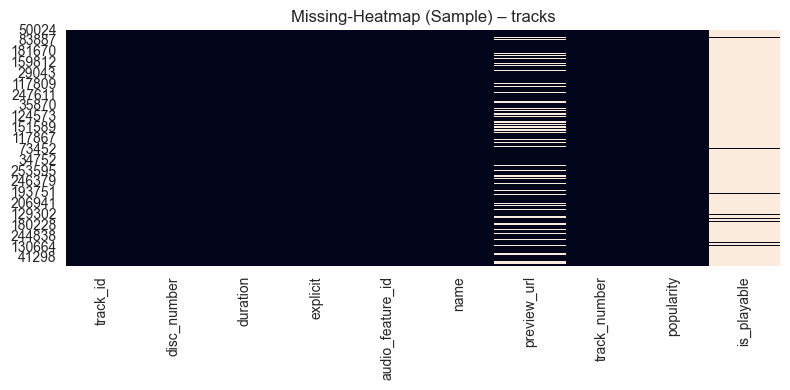


=== AUDIO_FEATURES ===


,missing_pct
id,0.0
acousticness,0.0
analysis_url,0.0
danceability,0.0
duration,0.0
energy,0.0
instrumentalness,0.0
key,0.0
liveness,0.0
loudness,0.0


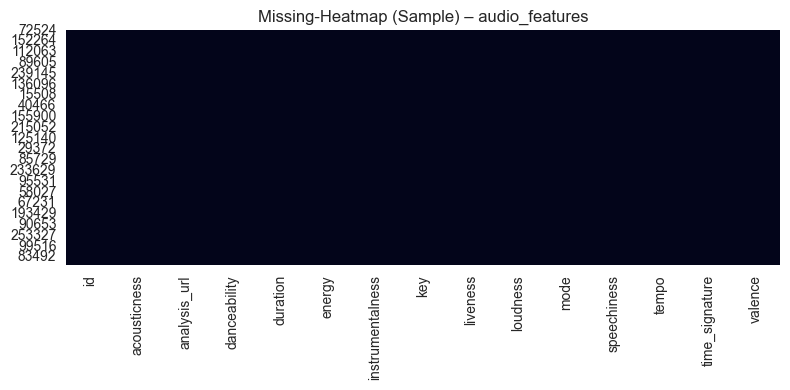


=== ARTISTS ===


,missing_pct
name,0.0
id,0.0
popularity,0.0
followers,0.0


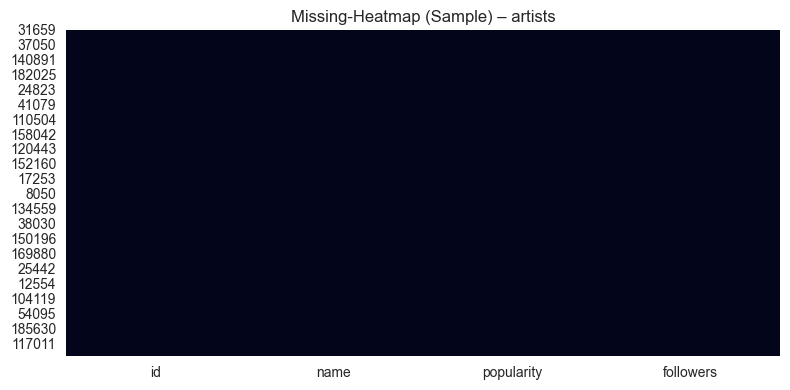


=== ALBUMS ===


,missing_pct
album_group,100.00
name,0.03
id,0.00
album_type,0.00
release_date,0.00
popularity,0.00


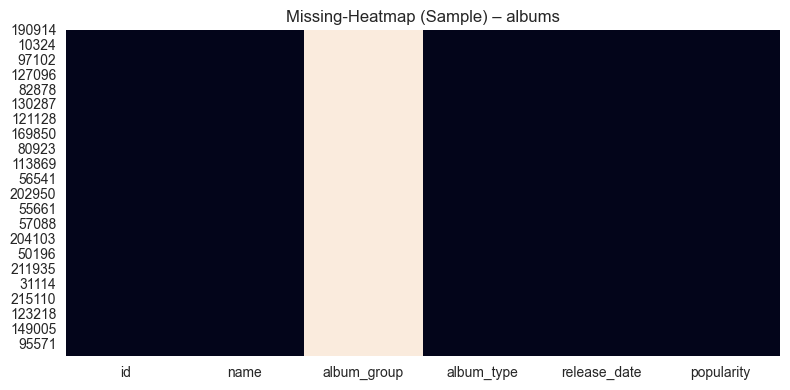

 Missing-Reports gespeichert unter: C:\GitHub\data-science\uni-course\spotify-data-project\data\reports\01_eda\missing


In [72]:
from pathlib import Path
from datetime import datetime

DATA_DIR = Path("../data/interim/converted_sqlite")
RUN_TS = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
REPORT_DIR = Path(f"../data/reports/01_eda/missing")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

tables = {}
for name, fname in [
    ("tracks", "tracks.csv"),
    ("audio_features", "audio_features.csv"),
    ("artists", "artists.csv"),
    ("albums", "albums.csv"),
]:
    p = DATA_DIR / fname
    if p.exists():
        tables[name] = pd.read_csv(p)


def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    ms = (df.isna().mean() * 100).sort_values(ascending=False).round(2)
    return ms.to_frame("missing_pct")


for name, df in tables.items():
    print(f"\n=== {name.upper()} ===")
    ms = missing_summary(df)
    display(ms.head(20))
    ms.to_csv(REPORT_DIR / f"missing_{name}.csv", encoding="utf-8")
    # Heatmap (nur bei breiten Tabellen sinnvoll)
    plt.figure(figsize=(8, 4))
    sns.heatmap(df.sample(min(len(df), 1000), random_state=42).isna(), cbar=False)
    plt.title(f"Missing-Heatmap (Sample) – {name}")
    plt.tight_layout()
    plt.savefig(REPORT_DIR / f"missing_heatmap_{name}.png", dpi=150)
    plt.show()

print(f" Missing-Reports gespeichert unter: {REPORT_DIR.resolve()}")


#### Fehlende Werte – Zusammenfassung

Die Überprüfung der fehlenden Werte zeigt, dass **nur die Tabellen `tracks` und `albums`** relevante Lücken enthalten.
Alle anderen Datensätze (Artists, Audio-Features, Genres, Verknüpfungstabellen) sind **vollständig** und weisen **keine fehlenden Werte** auf.

---

####  Tracks
- **is_playable (95.23 %)** – größtenteils leer; betrifft Songs, die vermutlich aufgrund von Lizenz- oder Regionsbeschränkungen nicht verfügbar sind.
- **preview_url (26.11 %)** – rund ein Viertel der Songs ohne Hörprobe.
- **name (0.04 %)**, **audio_feature_id (0.01 %)** – minimale Ausfälle, praktisch irrelevant.
- Alle anderen Spalten (`duration`, `explicit`, `track_number`, `popularity` u. a.) sind vollständig.

 **Bewertung:**
Die `tracks`-Tabelle ist insgesamt solide, enthält aber signifikante Lücken bei `is_playable` und `preview_url`. Diese Felder sollten bei späteren Analysen **bewusst behandelt oder ausgeschlossen** werden.

---

####  Albums
- **album_group (100 %)** – komplett leer, keine nutzbaren Informationen.
- **name (0.09 %)** – vereinzelte fehlende Werte.
- Alle übrigen Felder (`album_type`, `release_date`, `popularity`, `id`) sind vollständig.

 **Bewertung:**
Die `albums`-Tabelle weist nur ein inhaltlich bedeutungsloses Feld (`album_group`) auf. Ansonsten ist die Datenqualität **sehr hoch**.

---


### 1.7 Eindeutigkeit, Duplikate & Fremdschlüssel-Integrität

**Ziel**
Ich prüfe die Datenintegrität:
- Eindeutigkeit der Primärschlüssel (z. B. `id`)
- Duplikate pro Tabelle
- Fremdschlüssel-Konsistenz (z. B. `r_track_artist.track_id` existiert in `tracks.id`)

**Ergebnis**
- `integrity_report.csv` mit Kennzahlen
- ggf. Listen der verletzten Referenzen


In [73]:
import pandas as pd
from pathlib import Path

# 1) Pfade – passe bei Bedarf an (hier: schneller konsistenter Export)
DATA_DIR = Path("../data/interim/converted_sqlite")   # oder ../data/interim/sqlite_consistent
INTEG_DIR = Path(f"../data/reports/01_eda/integrity")
INTEG_DIR.mkdir(parents=True, exist_ok=True)

def load(name):
    p = DATA_DIR / f"{name}.csv"
    return pd.read_csv(p) if p.exists() else None

# 2) Laden
tracks = load("tracks")
audio   = load("audio_features")
artists = load("artists")
albums  = load("albums")
rta     = load("r_track_artist")
rat     = load("r_albums_tracks")
rag     = load("r_artist_genre")
genres  = load("genres")

# 3) Utils
def key_col_for(table_name: str) -> str:
    # in deinem Export hat nur tracks die Spalte "track_id", alle anderen "id"
    return "track_id" if table_name == "tracks" else "id"

def pct(part, whole):
    return 0.0 if whole == 0 else round(100.0 * part / whole, 3)

rows = []

def report_row(table, check, status, n_bad, n_total):
    rows.append({
        "table": table,
        "check": check,
        "status": status,
        "n_bad": int(n_bad) if n_bad is not None else None,
        "n_total": int(n_total) if n_total is not None else None,
        "pct_bad": pct(n_bad, n_total) if (n_bad is not None and n_total) else None
    })

# 4) Duplikate + (optional) ID-Eindeutigkeit pro Tabelle
def check_table(table_name: str, df: pd.DataFrame):
    if df is None:
        report_row(table_name, "duplicates_all_cols", "skip", None, None)
        report_row(table_name, f"unique({key_col_for(table_name)})", "skip", None, None)
        return
    # Duplikate über alle Spalten
    dups = df.duplicated().sum()
    report_row(table_name, "duplicates_all_cols", "ok" if dups == 0 else "warn", dups, len(df))

    # ID-Eindeutigkeit wenn Key existiert
    key = key_col_for(table_name)
    if key in df.columns:
        dup_ids = df[key].duplicated().sum()
        report_row(table_name, f"unique({key})", "ok" if dup_ids == 0 else "warn", dup_ids, len(df))
    else:
        report_row(table_name, f"unique({key})", "skip", None, None)

for name, df in [("tracks", tracks), ("audio_features", audio), ("artists", artists), ("albums", albums),("genres", genres),]:
    check_table(name, df)

# 5) Fremdschlüssel-Checks (Schema-bewusst)
def fk_check(child_df, child_key, parent_df, parent_key, table_label):
    if child_df is None or parent_df is None or child_key not in child_df.columns or parent_key not in parent_df.columns:
        report_row(table_label, f"fk({child_key}->{table_label.split(':')[-1]})", "skip", None, None)
        return
    total = len(child_df)
    missing = (~child_df[child_key].isin(parent_df[parent_key])).sum()
    report_row(table_label, f"fk({child_key}->{parent_key})", "ok" if missing == 0 else "warn", missing, total)

# r_track_artist: track_id -> tracks.track_id ; artist_id -> artists.id
if rta is not None:
    fk_check(rta, "track_id", tracks, key_col_for("tracks"), "r_track_artist:tracks")
    fk_check(rta, "artist_id", artists, key_col_for("artists"), "r_track_artist:artists")

# r_albums_tracks: track_id -> tracks.track_id ; album_id -> albums.id
if rat is not None:
    fk_check(rat, "track_id", tracks, key_col_for("tracks"), "r_albums_tracks:tracks")
    fk_check(rat, "album_id", albums, key_col_for("albums"), "r_albums_tracks:albums")

# tracks.audio_feature_id -> audio_features.id
if tracks is not None and audio is not None and "audio_feature_id" in tracks.columns and "id" in audio.columns:
    total = tracks["audio_feature_id"].notna().sum()
    missing = (~tracks.loc[tracks["audio_feature_id"].notna(), "audio_feature_id"].isin(audio["id"])).sum()
    report_row("tracks", "fk(audio_feature_id->audio_features.id)", "ok" if missing == 0 else "warn", missing, total)
else:
    report_row("tracks", "fk(audio_feature_id->audio_features.id)", "skip", None, None)


fk_check(rag, "artist_id", artists, key_col_for("artists"), "r_artist_genre:artists")

fk_check(rag, "genre_id", genres, key_col_for("genres"), "r_artist_genre:genres")


# 6) Ausgabe
integ = pd.DataFrame(rows).sort_values(["table","check"]).reset_index(drop=True)
display(integ)

# Save
out_csv = INTEG_DIR / "integrity_report.csv"
integ.to_csv(out_csv, index=False, encoding="utf-8")
print(" Integrity-Report gespeichert unter:", out_csv.resolve())


,table,check,status,n_bad,n_total,pct_bad
0,albums,duplicates_all_cols,ok,0,223856,0.0
1,albums,unique(id),ok,0,223856,0.0
2,artists,duplicates_all_cols,ok,0,189566,0.0
3,artists,unique(id),ok,0,189566,0.0
4,audio_features,duplicates_all_cols,ok,0,261951,0.0
5,audio_features,unique(id),ok,0,261951,0.0
6,genres,duplicates_all_cols,ok,0,5452,0.0
7,genres,unique(id),ok,0,5452,0.0
8,r_albums_tracks:albums,fk(album_id->id),ok,0,296269,0.0
9,r_albums_tracks:tracks,fk(track_id->track_id),ok,0,296269,0.0


 Integrity-Report gespeichert unter: C:\GitHub\data-science\uni-course\spotify-data-project\data\reports\01_eda\integrity\integrity_report.csv
